# Image Classification: Detecting Pediatric Pneumonia

## Overview

## Business Understanding

## Data Understanding

## Data Preparation

In [1]:
#importing packages
import pandas as pd 
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os

from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.models import load_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, classification_report, precision_score
from sklearn.model_selection import cross_val_score
from tensorflow.keras import metrics
from tensorflow.keras.wrappers import scikit_learn

from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay


np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
#use the splitfolders package to split our image data into train, validation, and test sets.
#this is now commented out so that we don't create a new folder each time we run the notebook


#splitfolders.ratio("Data", output="Data_Split",
#    seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [4]:
# Using ImageDataGenerator to rescale all images 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=3747,
        color_mode='grayscale',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 3749 images belonging to 2 classes.


In [6]:
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=936,
                                                        color_mode='grayscale',
                                                        class_mode='binary')
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 936 images belonging to 2 classes.
Found 1107 images belonging to 2 classes.


In [7]:
#Creating the augumented data

aug_train_images = ImageDataGenerator(rotation_range=30, 
                                   width_shift_range=0.25, 
                                   height_shift_range=0.25, 
                                   shear_range=0.25, 
                                   zoom_range=0.25, 
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_aug = aug_train_images.flow_from_directory('Data_Split/train',
                                                  target_size=(150, 150),
                                                  batch_size=3747,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 3749 images belonging to 2 classes.


In [8]:
#getting images and labels for models
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [9]:
#reshaping
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
val_data = val_data.reshape(val_data.shape[0], -1)
train_data.shape

(3747, 22500)

In [ ]:
# Function to show model metrics

### Dummy Model
We will use a dummy model classifier as our baseline model. This model will predict the majority class. Since the majority class in our data is pneumonia, this model will predict all images are pneumonia.

In [ ]:
dummy_model =  DummyClassifier(strategy='most_frequent')
dummy_model.fit(train_data, train_labels)

In [ ]:
y_preds_dummy = dummy_model.predict(val_data)

In [ ]:
dummy_acc = dummy_model.score(val_data, val_labels)
dummy_rec = recall_score(val_labels,y_preds_dummy)
dummy_pre = precision_score(val_labels,y_preds_dummy)

print(f"Dummy Model accuracy: {dummy_acc}")
print(f"Dummy Model recall: {dummy_rec}")
print(f"Dummy Model precision: {dummy_pre}")

In [ ]:
# Confusion matrix for dummy model
plot_confusion_matrix(dummy_model, val_data, val_labels);

### Simple Model 1
Our first model will be a simple model - this will give us an idea of what improvements

In [10]:
simple_model = models.Sequential()

In [11]:
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid')) 

In [12]:
simple_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                270012    
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 270,025
Trainable params: 270,025
Non-trainable params: 0
_________________________________________________________________


In [13]:
simple_model_history = simple_model.fit(train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 3s 12ms/step - loss: 0.5052 - accuracy: 0.7302 - precision: 0.7358 - recall: 0.9832 - val_loss: 0.5015 - val_accuracy: 0.7318 - val_precision: 0.7313 - val_recall: 1.0000
Epoch 2/10
118/118 [==============================] - 1s 10ms/step - loss: 0.3950 - accuracy: 0.8332 - precision: 0.8353 - recall: 0.9609 - val_loss: 0.5198 - val_accuracy: 0.7457 - val_precision: 0.9933 - val_recall: 0.6559
Epoch 3/10
118/118 [==============================] - 1s 10ms/step - loss: 0.3499 - accuracy: 0.8631 - precision: 0.8781 - recall: 0.9433 - val_loss: 0.3247 - val_accuracy: 0.8718 - val_precision: 0.8559 - val_recall: 0.9912
Epoch 4/10
118/118 [==============================] - 1s 7ms/step - loss: 0.3210 - accuracy: 0.8871 - precision: 0.8959 - recall: 0.9565 - val_loss: 0.5356 - val_accuracy: 0.6806 - val_precision: 1.0000 - val_recall: 0.5622
Epoch 5/10
118/118 [==============================] - 1s 8ms/step - loss: 0.3097 - accuracy: 0.8970 -

In [14]:
simple_model.evaluate(val_data, val_labels)

30/30 [==============================] - 0s 5ms/step - loss: 1.0938 - accuracy: 0.7350 - precision: 0.7336 - recall: 1.0000


[1.093813180923462, 0.7350427508354187, 0.733619749546051, 1.0]

<AxesSubplot:>

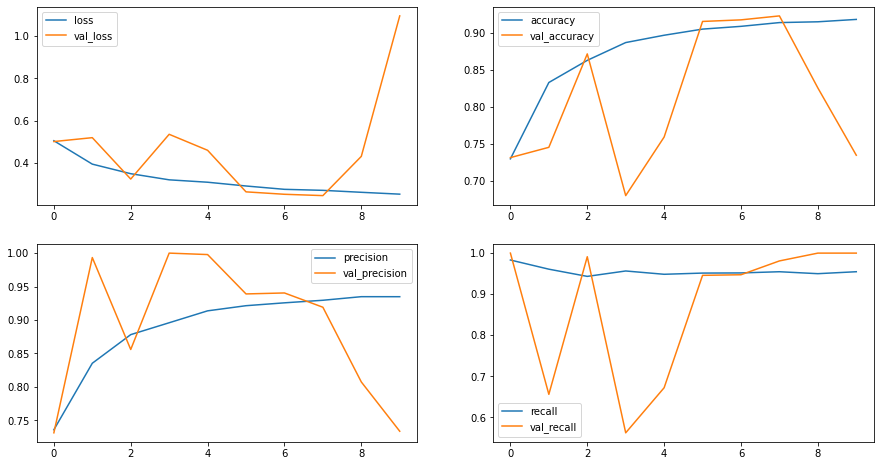

In [15]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

loss = simple_model_history.history['loss']
accuracy = simple_model_history.history['accuracy']
precision = simple_model_history.history['precision']
recall = simple_model_history.history['recall']

validation_loss = simple_model_history.history['val_loss']
validation_accuracy = simple_model_history.history['val_accuracy']
validation_precision = simple_model_history.history['val_precision']
validation_recall = simple_model_history.history['val_recall']

sns.lineplot(simple_model_history.epoch, simple_model_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_recall'], y=recall, ax=ax4, label='val_recall')



### CNN Model 1
Our basic CNN model

In [16]:
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [17]:
cnn1_model = models.Sequential()
cnn1_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                    input_shape=(150, 150, 1)))
cnn1_model.add(layers.MaxPooling2D((2, 2)))
cnn1_model.add(layers.Flatten())
cnn1_model.add(layers.Dense(16, activation='relu'))
cnn1_model.add(layers.Dense(1, activation='sigmoid'))

cnn1_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                5456912   
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,458,017
Trainable params: 5,458,017
Non-trainable params: 0
____________________________________________

In [18]:
cnn1_history = cnn1_model.fit(train_data,
               train_labels,
               batch_size=30,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.6322 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.8763 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/10
1/1 [==============================] - 7s 7s/step - loss: 2.8201e-08 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.2392 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 2.5695e-13 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 10.9256 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 2.3875e-17 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 13.1839 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 9.6976e-21 - accuracy: 1.0000 - precision

In [19]:
cnn1_model.save('models/cnn1')

INFO:tensorflow:Assets written to: models/cnn1/assets


INFO:tensorflow:Assets written to: models/cnn1/assets


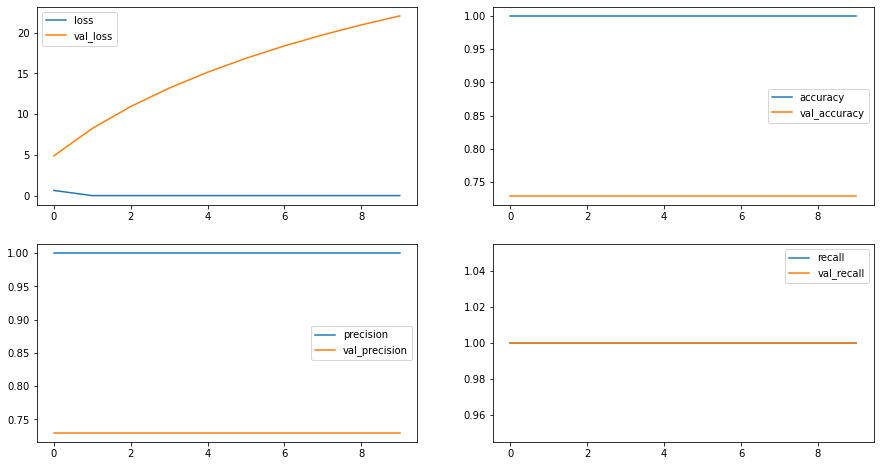

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn1_history.epoch, cnn1_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [21]:
results = cnn1_model.evaluate(validation_generator)

1/1 [==============================] - 47s 47s/step - loss: 22.0418 - accuracy: 0.7297 - precision: 0.7297 - recall: 1.0000


In [22]:
print(f"Model loss: {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss: 22.04181671142578
Model accuracy: 0.7297008633613586
Model precision: 0.7297008633613586
Model recall: 1.0


In [ ]:
#CONFUSION MATRIX

## CNN Model 2
description

In [24]:
cnn2_model = models.Sequential()
cnn2_model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                            input_shape=(150,150,1)))
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Flatten())
cnn2_model.add(Dense(16, activation='relu'))
cnn2_model.add(Dense(1, activation='sigmoid')) 

cnn2_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 16)               

In [25]:
cnn2_history = cnn2_model.fit(train_data,
               train_labels,
               batch_size=50,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
1/1 [==============================] - 15s 15s/step - loss: 0.6893 - accuracy: 0.5000 - precision: 1.0000 - recall: 0.5000 - val_loss: 0.7673 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/10
1/1 [==============================] - 14s 14s/step - loss: 0.0733 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.4736 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2944 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 4/10
1/1 [==============================] - 10s 10s/step - loss: 2.2411e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.1152 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 5/10
1/1 [==============================] - 11s 11s/step - loss: 1.2599e-05 - accuracy: 1.0000 - precision

In [26]:
cnn2_model.save('models/cnn2')

INFO:tensorflow:Assets written to: models/cnn2/assets


INFO:tensorflow:Assets written to: models/cnn2/assets


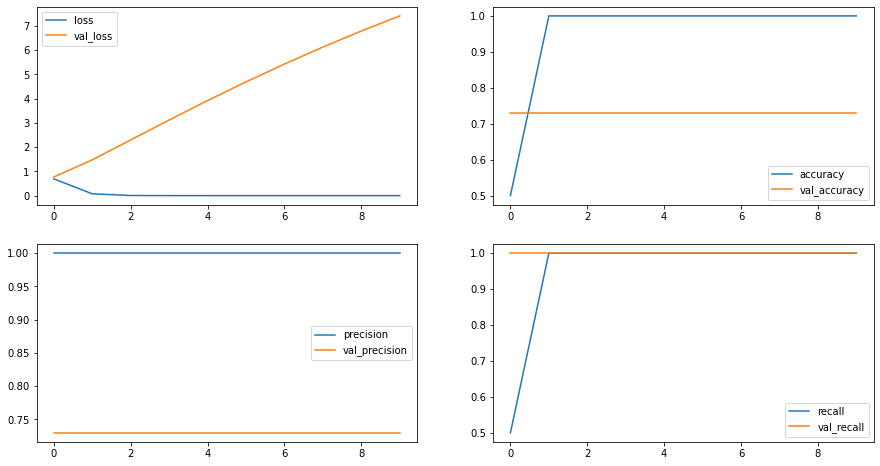

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn2_history.epoch, cnn2_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [28]:
cnn2_model.evaluate(validation_generator)

1/1 [==============================] - 49s 49s/step - loss: 7.4039 - accuracy: 0.7297 - precision: 0.7297 - recall: 1.0000


[7.403892993927002, 0.7297008633613586, 0.7297008633613586, 1.0]

In [ ]:
CONFUSION MATRIX

### CNN Model 3

In [ ]:
cnn3_model = models.Sequential()
cnn3_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                      input_shape=(150, 150, 1)))
cnn3_model.add(layers.MaxPooling2D((2, 2)))
cnn3_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn3_model.add(layers.MaxPooling2D((2,2)))
cnn3_model.add(layers.Flatten())
cnn3_model.add(layers.Dense(16, activation='relu'))
cnn3_model.add(layers.Dense(1, activation='sigmoid'))

cnn3_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn3_model.summary()

In [ ]:
cnn3_history = cnn3_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

In [ ]:
cnn3_model.save('models/cnn3')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn3_history.epoch, cnn3_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [ ]:
cnn3_model.evaluate(validation_generator)

### CNN Model 4

In [ ]:
cnn4_model = models.Sequential()
cnn4_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2, 2)))
cnn4_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2,2)))
cnn4_model.add(layers.Flatten())
cnn4_model.add(layers.Dense(16, activation='relu'))
cnn4_model.add(layers.Dense(1, activation='sigmoid'))

cnn4_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
cnn4_model.summary()

In [ ]:
cnn4_history = cnn4_model.fit(train_data,
              train_labels,
              batch_size=32,
              epochs=10,
              validation_data=(val_data, val_labels))

In [ ]:
cnn4_model.save('models/cnn4')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn4_history.epoch, cnn4_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [ ]:
cnn4_model.evaluate(validation_generator)

### CNN Model 5

In [ ]:
cnn5_model = models.Sequential()
cnn5_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2, 2)))
cnn5_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2,2)))
cnn5_model.add(layers.Flatten())
cnn5_model.add(layers.Dense(16, activation='relu'))
cnn5_model.add(layers.Dropout(0.5))
cnn5_model.add(layers.Dense(1, activation='sigmoid'))

cnn5_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn5_model.summary()

In [ ]:
cnn5_history = cnn5_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

In [ ]:
cnn5_model.save('models/cnn5')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn5_history.epoch, cnn5_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [ ]:
cnn5_model.evaluate(validation_generator)

### CNN Model 6

In [ ]:
cnn6_model = models.Sequential()
cnn6_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2, 2)))
cnn6_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2,2)))
cnn6_model.add(layers.Flatten())
cnn6_model.add(layers.Dense(16, activation='relu'))
cnn6_model.add(layers.Dropout(0.3))
cnn6_model.add(layers.Dense(1, activation='sigmoid'))

cnn6_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn6_model.summary()

In [ ]:
cnn6_history = cnn6_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

In [ ]:
cnn6_model.save('models/cnn6')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn6_history.epoch, cnn6_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [ ]:
cnn6_model.evaluate(validation_generator)

### CNN Model 7

In [ ]:
cnn7_model = models.Sequential()
cnn7_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2, 2)))
cnn7_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2,2)))
cnn7_model.add(layers.Flatten())
cnn7_model.add(layers.Dense(16, activation='relu'))
cnn7_model.add(layers.Dropout(0.3))
cnn7_model.add(layers.Dense(1, activation='sigmoid'))

cnn7_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
cnn7_model.summary()

In [ ]:
cnn7_history = cnn7_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

In [ ]:
cnn7_model.save('models/cnn7')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn7_history.epoch, cnn7_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [ ]:
cnn7_model.evaluate(validation_generator)

### CNN Model 8

In [ ]:

cnn8_model = models.Sequential()
cnn8_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Flatten())
cnn8_model.add(layers.Dense(16, activation='relu'))
cnn8_model.add(layers.Dropout(0.3))
cnn8_model.add(layers.Dense(1, activation='sigmoid'))

cnn8_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn8_model.summary()

In [ ]:
cnn8_history = cnn8_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

In [ ]:
cnn8_model.save('models/cnn8')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn8_history.epoch, cnn8_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [ ]:
cnn8_model.evaluate(validation_generator)

### CNN Model 9

In [ ]:
cnn9_model = models.Sequential()
cnn9_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Flatten())
cnn9_model.add(layers.Dense(16, activation='relu'))
cnn9_model.add(layers.Dropout(0.3))
cnn9_model.add(layers.Dense(1, activation='sigmoid'))

cnn9_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn9_model.summary()

In [ ]:
cnn9_history = cnn9_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

In [ ]:
cnn9_model.save('models/cnn9')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn9_history.epoch, cnn9_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [ ]:
cnn9_model.evaluate(validation_generator)

### CNN Model 10

In [ ]:
cnn10_model = models.Sequential()
cnn10_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Flatten())
cnn10_model.add(layers.Dense(16, activation='relu'))
cnn10_model.add(layers.Dropout(0.3))
cnn10_model.add(layers.Dense(1, activation='sigmoid'))

cnn10_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='max')

cnn10_model.summary()

In [ ]:
cnn10_history = cnn10_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

In [ ]:
cnn10_model.save('models/cnn10')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn10_history.epoch, cnn10_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [ ]:
cnn10_model.evaluate(validation_generator)

### CNN Model 11

In [ ]:
cnn11_model = models.Sequential()
cnn11_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Flatten())
cnn11_model.add(layers.Dense(16, activation='relu'))
cnn11_model.add(layers.Dropout(0.3))
cnn11_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn11_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn11_model.summary()

In [ ]:
cnn11_history = cnn11_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

In [ ]:
cnn11_model.save('models/cnn11')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn11_history.epoch, cnn11_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [ ]:
cnn11_model.evaluate(validation_generator)

### CNN Model 12

In [23]:
cnn12_model = models.Sequential()
cnn12_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Flatten())
cnn12_model.add(layers.Dense(16, activation='relu'))
cnn12_model.add(layers.Dropout(0.3))
cnn12_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn12_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(name='precision', thresholds=0.3), metrics.Recall(name='recall', thresholds=0.3)]) 

cnn12_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 16)               

In [ ]:
cnn12_history = cnn12_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=30,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

In [ ]:
cnn12_model.save('models/cnn12')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn12_history.epoch, cnn12_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [ ]:
cnn12_model.evaluate(validation_generator)